#Henry Saltwater Intrusion Problem

In this notebook, we will use Flopy to create, run, and post process the Henry saltwater intrusion problem using SEAWAT Version 4.

In [26]:
%matplotlib inline
import os
import numpy as np
import flopy

workspace = os.path.join('data')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)

In [27]:
# Input variables for the Henry Problem
Lx = 2.
Lz = 1.
nlay = 50
nrow = 1
ncol = 100
delr = Lx / ncol
delc = 1.0
delv = Lz / nlay
henry_top = 1.
henry_botm = np.linspace(henry_top - delv, 0., nlay)
qinflow = 5.702  #m3/day
dmcoef = 0.57024 #m2/day  Could also try 1.62925 as another case of the Henry problem
hk = 864.  #m/day

In [28]:
# Create the basic MODFLOW model structure
modelname = 'henry'
mf = flopy.modflow.Modflow(modelname, exe_name='swt_v4', model_ws=workspace)


# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, nper=1, delr=delr,
                               delc=delc, laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=1.5, nstp=15)

# Variables for the BAS package
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, -1] = -1
bas = flopy.modflow.ModflowBas(mf, ibound, 0)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=hk)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(mf, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(mf, 
                             stress_period_data={(0, 0): ['save head', 'save budget']},
                             compact=True)

# Create WEL and SSM data
itype = flopy.mt3d.Mt3dSsm.itype_dict()
wel_data = {}
ssm_data = {}
wel_sp1 = []
ssm_sp1 = []
for k in range(nlay):
    wel_sp1.append([k, 0, 0, qinflow / nlay])
    ssm_sp1.append([k, 0, 0, 0., itype['WEL']])
    ssm_sp1.append([k, 0, ncol - 1, 35., itype['BAS6']])
wel_data[0] = wel_sp1
ssm_data[0] = ssm_sp1
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_data)

In [29]:
# Create the basic MT3DMS model structure
mt = flopy.mt3d.Mt3dms(modelname, 'nam_mt3dms', mf, model_ws=workspace)
btn = flopy.mt3d.Mt3dBtn(mt, nprs=-5, prsity=0.35, sconc=35., ifmtcn=0,
                         chkmas=False, nprobs=10, nprmas=10, dt0=0.001)
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=0)
dsp = flopy.mt3d.Mt3dDsp(mt, al=0., trpt=1., trpv=1., dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(mt, iter1=500, mxiter=1, isolve=1, cclose=1e-7)
ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data)

# Create the SEAWAT model structure
mswt = flopy.seawat.Seawat(modelname, 'nam_swt', mf, mt, model_ws=workspace, exe_name='swt_v4')
vdf = flopy.seawat.SeawatVdf(mswt, iwtable=0, densemin=0, densemax=0,
                             denseref=1000., denseslp=0.7143, firstdt=1e-3)

In [30]:
# Write the input files
mf.write_input()
mt.write_input()
mswt.write_input()

In [31]:
# Try to delete the output files, to prevent accidental use of older files
try:
    os.remove(os.path.join(workspace, 'MT3D001.UCN'))
    os.remove(os.path.join(workspace, modelname + '.hds'))
    os.remove(os.path.join(workspace, modelname + '.cbc'))
except:
    pass

In [32]:
mswt.run_model(silent=True)

(True, [])

In [33]:
# Post-process the results
import numpy as np
import flopy.utils.binaryfile as bf

# Load data
ucnobj = bf.UcnFile(os.path.join(workspace, 'MT3D001.UCN'),model=mf)
times = ucnobj.get_times()
concentration = ucnobj.get_data(totim=times[-1])
cbbobj = bf.CellBudgetFile(os.path.join(workspace, 'henry.cbc'))
times = cbbobj.get_times()
qx = cbbobj.get_data(text='flow right face', totim=times[-1])[0]
qz = cbbobj.get_data(text='flow lower face', totim=times[-1])[0]

# Average flows to cell centers
qx_avg = np.empty(qx.shape, dtype=qx.dtype)
qx_avg[:, :, 1:] = 0.5 * (qx[:, :, 0:ncol-1] + qx[:, :, 1:ncol])
qx_avg[:, :, 0] = 0.5 * qx[:, :, 0]
qz_avg = np.empty(qz.shape, dtype=qz.dtype)
qz_avg[1:, :, :] = 0.5 * (qz[0:nlay-1, :, :] + qz[1:nlay, :, :])
qz_avg[0, :, :] = 0.5 * qz[0, :, :]

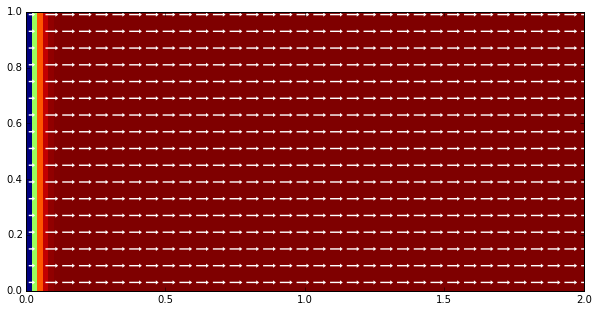

In [34]:
# Make the plot
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.imshow(concentration[:, 0, :], interpolation='nearest',
           extent=(0, Lx, 0, Lz))
y, x, z = dis.get_node_coordinates()
X, Z = np.meshgrid(x, z[:, 0, 0])
iskip = 3
ax.quiver(X[::iskip, ::iskip], Z[::iskip, ::iskip],
           qx_avg[::iskip, 0, ::iskip], -qz_avg[::iskip, 0, ::iskip],
           color='w', scale=5, headwidth=3, headlength=2,
           headaxislength=2, width=0.0025)
plt.savefig(os.path.join(workspace, 'henry.png'))
plt.show()

In [35]:
# Extract the heads
fname = os.path.join(workspace, 'henry.hds')
headobj = bf.HeadFile(fname)
times = headobj.get_times()
head = headobj.get_data(totim=times[-1])

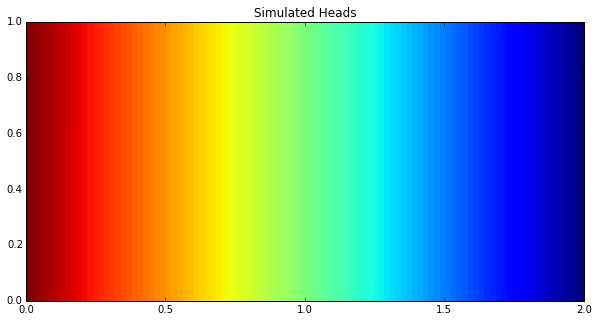

In [36]:
# Make a simple head plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
im = ax.imshow(head[:, 0, :], interpolation='nearest',
               extent=(0, Lx, 0, Lz))
ax.set_title('Simulated Heads')

In [37]:
mt.btn.prsity.how = "constant"
mt.btn.prsity[0].how = "internal"
mt.btn.prsity[1].how = "external"
mt.btn.sconc[0].how = "external"
mt.btn.prsity[0].fmtin = "(100E15.6)"
mf.lpf.hk[0].fmtin = "(BINARY)"


In [38]:
mf.write_input()
mt.write_input()
mswt.write_input()
mswt.run_model(silent=False)

Util2d:hk layer 1 warning: resetting 'how' to external since format is binary
FloPy is using the following executable to run the model: /Users/jwhite/bin/swt_v4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: henry.nam_swt                                                                                                                                                                                           
 Run start date and time (yyyy/mm/dd 

(True, [])